# Movie Recommendation System

In [1]:
from collections import Counter

import pandas as pd
import numpy as np

from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt
import seaborn as sns

import pickle as pk
from ast import literal_eval

from jupyterthemes import jtplot
jtplot.style(figsize=(15, 9))

## Data Cleaning

In [2]:
cast_df = pd.read_csv('../data/popular_10000_movies/cast_dataset.csv', index_col='id')
crew_df = pd.read_csv('../data/popular_10000_movies/crew_dataset.csv', index_col='id')
keywords_df = pd.read_csv('../data/popular_10000_movies/keywords_dataframe.csv', index_col='id')
mov_df = pd.read_csv('../data/popular_10000_movies/movies_dataset.csv', index_col='id')

In [3]:
keywords_df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [4]:
movies_df = mov_df.merge(cast_df, on='id').merge(crew_df, on ='id').merge(keywords_df, on ='id')
movies_df['release_date'] = pd.to_datetime(movies_df['release_date'])

In [5]:
movies_df.head()

,genre_ids,original_language,overview,popularity,release_date,title,vote_average,vote_count,genres,cast,crew,keywords
id,,,,,,,,,,,,
385687,"[28, 80, 53]",en,Over many missions and against impossible odds...,4654.279,2023-05-17,Fast X,7.3,2093,"Action, Crime, Thriller","[{'cast_id': 12835, 'name': 'Vin Diesel', 'cha...","[{'crew_id': 1302, 'name': 'Susie Figgis', 'de...","[{'id': 9663, 'name': 'sequel'}, {'id': 9748, ..."
697843,"[28, 53]",en,Tasked with extracting a family who is at the ...,2494.010,2023-06-09,Extraction 2,7.7,910,"Action, Thriller","[{'cast_id': 74568, 'name': 'Chris Hemsworth',...","[{'crew_id': 950, 'name': 'Pietro Scalia', 'de...","[{'id': 3070, 'name': 'mercenary'}, {'id': 966..."
603692,"[28, 53, 80]",en,"With the price on his head ever increasing, Jo...",1920.127,2023-03-22,John Wick: Chapter 4,7.9,3344,"Action, Thriller, Crime","[{'cast_id': 6384, 'name': 'Keanu Reeves', 'ch...","[{'crew_id': 3615, 'name': 'Manfred Banach', '...","[{'id': 242, 'name': 'new york city'}, {'id': ..."
569094,"[28, 12, 16, 878]",en,"After reuniting with Gwen Stacy, Brooklyn’s fu...",2013.795,2023-05-31,Spider-Man: Across the Spider-Verse,8.6,1796,"Action, Adventure, Animation, Science Fiction","[{'cast_id': 587506, 'name': 'Shameik Moore', ...","[{'crew_id': 7624, 'name': 'Stan Lee', 'depart...","[{'id': 2858, 'name': 'sacrifice'}, {'id': 328..."
502356,"[16, 10751, 12, 14, 35]",en,"While working underground to fix a water main,...",1539.037,2023-04-05,The Super Mario Bros. Movie,7.8,5165,"Animation, Family, Adventure, Fantasy, Comedy","[{'cast_id': 73457, 'name': 'Chris Pratt', 'ch...","[{'crew_id': 70851, 'name': 'Jack Black', 'dep...","[{'id': 282, 'name': 'video game'}, {'id': 690..."


In [6]:
movies_df.shape

(10652, 12)

In [7]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10652 entries, 385687 to 465109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   genre_ids          10652 non-null  object        
 1   original_language  10652 non-null  object        
 2   overview           10649 non-null  object        
 3   popularity         10652 non-null  float64       
 4   release_date       10636 non-null  datetime64[ns]
 5   title              10652 non-null  object        
 6   vote_average       10652 non-null  float64       
 7   vote_count         10652 non-null  int64         
 8   genres             10634 non-null  object        
 9   cast               10652 non-null  object        
 10  crew               10652 non-null  object        
 11  keywords           10652 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(8)
memory usage: 749.0+ KB


In [8]:
movies_df['original_language'].value_counts()

en    10652
Name: original_language, dtype: int64

In [9]:
movies_df.drop('original_language', axis=1, inplace=True)

In [10]:
movies_df.isnull().sum()

genre_ids        0
overview         3
popularity       0
release_date    16
title            0
vote_average     0
vote_count       0
genres          18
cast             0
crew             0
keywords         0
dtype: int64

In [11]:
movies_df.drop(movies_df[movies_df['keywords']=='[]'].index, axis=0, inplace=True)
movies_df.drop(movies_df[movies_df['cast']=='[]'].index, axis=0, inplace=True)
movies_df.drop(movies_df[movies_df['crew']=='[]'].index, axis=0, inplace=True)
movies_df.drop(movies_df[movies_df['vote_average']==0].index, axis=0, inplace=True)
movies_df.drop(movies_df[movies_df['vote_count']<100].index, axis=0, inplace=True)
movies_df.dropna(axis=0, inplace=True)

In [12]:
movies_df.isnull().sum()

genre_ids       0
overview        0
popularity      0
release_date    0
title           0
vote_average    0
vote_count      0
genres          0
cast            0
crew            0
keywords        0
dtype: int64

In [13]:
movies_df[movies_df.duplicated()].shape

(515, 11)

In [14]:
movies_df.drop_duplicates(inplace=True)

In [15]:
movies_df[movies_df.duplicated()].shape

(0, 11)

In [16]:
# Delete movies with useless keywords
idxs = [184, 476, 1094, 2022, 3655, 4071, 4485, 5432, 5535, 6655, 6885, 7481, 7504]
movies_df.drop(movies_df.iloc[idxs].index, axis=0, inplace=True)

In [17]:
movies_df.shape

(8388, 11)

## EDA

In [42]:
movies_df.groupby('genres').mean().sort_values(['vote_average'], ascending=False).head(10)

,popularity,vote_average,vote_count
genres,,,
"Fantasy, Drama, Crime",69.123,8.5,15537.0
"Drama, Thriller, Comedy",73.566,8.4,26647.0
"Animation, Family, Fantasy, Adventure, Comedy",502.086,8.3,5832.0
"Family, Animation, Drama",97.326,8.3,16649.0
"TV Movie, Animation, Science Fiction, Action, Adventure, Comedy, Drama, Fantasy, Music",24.249,8.3,754.0
"Horror, Music",12.705,8.2,581.0
"Animation, Family, Comedy, Fantasy, Drama",66.030,8.2,9233.0
"Family, Animation, Fantasy, Music, Comedy, Adventure",106.932,8.2,17338.0
"Family, Animation, Music",15.704,8.2,143.0


In [43]:
movies_df.groupby('genres').mean().sort_values(['vote_average'], ascending=True).head(10)

,popularity,vote_average,vote_count
genres,,,
"Science Fiction, Horror, Action, Thriller",13.295,2.9,117.0
"Action, Adventure, Fantasy, Science Fiction, Thriller",33.077,2.9,1867.0
"Fantasy, Science Fiction, Family, TV Movie",15.379,3.3,408.0
"Horror, Action, Comedy, Science Fiction, Adventure",11.146,3.9,1436.0
"Science Fiction, Comedy, Family",11.359,4.0,321.0
"Adventure, Thriller, Horror",18.743,4.1,885.0
"Crime, Fantasy, Horror, Thriller",16.582,4.2,3696.0
"Mystery, Adventure, Comedy, Crime",15.003,4.3,741.0
"Adventure, Horror, Action, Science Fiction",16.062,4.3,493.0


In [44]:
movies_df.groupby('genres').count().sort_values(['vote_average'], ascending=False).head(10)

,genre_ids,overview,popularity,release_date,title,vote_average,vote_count,cast,crew,keywords
genres,,,,,,,,,,
Drama,405,405,405,405,405,405,405,405,405,405
Comedy,344,344,344,344,344,344,344,344,344,344
"Comedy, Romance",222,222,222,222,222,222,222,222,222,222
"Drama, Romance",214,214,214,214,214,214,214,214,214,214
"Horror, Thriller",170,170,170,170,170,170,170,170,170,170
"Comedy, Drama",169,169,169,169,169,169,169,169,169,169
Horror,140,140,140,140,140,140,140,140,140,140
"Comedy, Drama, Romance",137,137,137,137,137,137,137,137,137,137
"Drama, History",100,100,100,100,100,100,100,100,100,100


In [45]:
movies_df.groupby('genres').count().sort_values(['vote_average'], ascending=False).tail(10)

,genre_ids,overview,popularity,release_date,title,vote_average,vote_count,cast,crew,keywords
genres,,,,,,,,,,
"Adventure, Drama, Thriller, History",1,1,1,1,1,1,1,1,1,1
"Adventure, Family, Animation, Action, Comedy",1,1,1,1,1,1,1,1,1,1
"Drama, Mystery, Western",1,1,1,1,1,1,1,1,1,1
"Drama, Mystery, Thriller, TV Movie",1,1,1,1,1,1,1,1,1,1
"Drama, Mystery, Thriller, Romance",1,1,1,1,1,1,1,1,1,1
"Drama, Mystery, Thriller, Horror",1,1,1,1,1,1,1,1,1,1
"Drama, Mystery, Thriller, History",1,1,1,1,1,1,1,1,1,1
"Drama, Mystery, Thriller, Fantasy",1,1,1,1,1,1,1,1,1,1
"Adventure, Family, Action, Fantasy",1,1,1,1,1,1,1,1,1,1


In [46]:
movies_df.sort_values(['vote_average'], ascending=False).head(10)

,genre_ids,overview,popularity,release_date,title,vote_average,vote_count,genres,cast,crew,keywords
id,,,,,,,,,,,
238,"[18, 80]","Spanning the years 1945 to 1955, a chronicle o...",120.966,1972-03-14,The Godfather,8.7,18141,"Drama, Crime","[{'cast_id': 3084, 'name': 'Marlon Brando', 'c...","[{'crew_id': 154, 'name': 'Walter Murch', 'dep...","[{'id': 131, 'name': 'italy'}, {'id': 697, 'na..."
278,"[18, 80]",Framed in the 1940s for the double murder of h...,107.982,1994-09-23,The Shawshank Redemption,8.7,24021,"Drama, Crime","[{'cast_id': 504, 'name': 'Tim Robbins', 'char...","[{'crew_id': 153, 'name': 'Thomas Newman', 'de...","[{'id': 378, 'name': 'prison'}, {'id': 417, 'n..."
373558,"[10402, 99]","Filmed in front of 76,000 fans at the ANZ Stad...",15.562,2015-12-20,Taylor Swift: The 1989 World Tour - Live,8.7,119,"Music, Documentary","[{'cast_id': 212208, 'name': 'Taylor Swift', '...","[{'crew_id': 71329, 'name': 'Jonas Åkerlund', ...","[{'id': 1740, 'name': 'pop culture'}, {'id': 2..."
569094,"[28, 12, 16, 878]","After reuniting with Gwen Stacy, Brooklyn’s fu...",2013.795,2023-05-31,Spider-Man: Across the Spider-Verse,8.6,1796,"Action, Adventure, Animation, Science Fiction","[{'cast_id': 587506, 'name': 'Shameik Moore', ...","[{'crew_id': 7624, 'name': 'Stan Lee', 'depart...","[{'id': 2858, 'name': 'sacrifice'}, {'id': 328..."
424,"[18, 36, 10752]",The true story of how businessman Oskar Schind...,60.506,1993-12-15,Schindler's List,8.6,14198,"Drama, History, War","[{'cast_id': 3896, 'name': 'Liam Neeson', 'cha...","[{'crew_id': 491, 'name': 'John Williams', 'de...","[{'id': 818, 'name': 'based on novel or book'}..."
240,"[18, 80]",In the continuing saga of the Corleone crime f...,68.191,1974-12-20,The Godfather Part II,8.6,10949,"Drama, Crime","[{'cast_id': 1158, 'name': 'Al Pacino', 'chara...","[{'crew_id': 154, 'name': 'Walter Murch', 'dep...","[{'id': 131, 'name': 'italy'}, {'id': 700, 'na..."
664280,[99],The story of life on our planet by the man who...,12.926,2020-09-28,David Attenborough: A Life on Our Planet,8.5,284,Documentary,"[{'cast_id': 86543, 'name': 'David Attenboroug...","[{'crew_id': 16368, 'name': 'Steven Price', 'd...","[{'id': 2210, 'name': 'climate change'}, {'id'..."
155,"[18, 28, 80, 53]",Batman raises the stakes in his war on crime. ...,90.659,2008-07-14,The Dark Knight,8.5,29936,"Drama, Action, Crime, Thriller","[{'cast_id': 3894, 'name': 'Christian Bale', '...","[{'crew_id': 1113, 'name': 'Lucinda Syson', 'd...","[{'id': 853, 'name': 'crime fighter'}, {'id': ..."
497,"[14, 18, 80]",A supernatural tale set on death row in a Sout...,69.123,1999-12-10,The Green Mile,8.5,15537,"Fantasy, Drama, Crime","[{'cast_id': 31, 'name': 'Tom Hanks', 'charact...","[{'crew_id': 153, 'name': 'Thomas Newman', 'de...","[{'id': 531, 'name': 'southern usa'}, {'id': 7..."


In [47]:
movies_df.sort_values(['vote_average'], ascending=True).head(10)

,genre_ids,overview,popularity,release_date,title,vote_average,vote_count,genres,cast,crew,keywords
id,,,,,,,,,,,
19157,[35],A struggling young comedian takes a menial job...,11.868,1989-05-11,Going Overboard,2.3,112,Comedy,"[{'cast_id': 19292, 'name': 'Adam Sandler', 'c...","[{'crew_id': 19292, 'name': 'Adam Sandler', 'd...","[{'id': 407, 'name': 'dictator'}, {'id': 2398,..."
10838,"[27, 878]","In the year 3000, the deep space salvage ship ...",11.360,2004-08-09,Dracula 3000,2.7,114,"Horror, Science Fiction","[{'cast_id': 27763, 'name': 'Casper Van Dien',...","[{'crew_id': 15303, 'name': 'Frank Hübner', 'd...","[{'id': 1826, 'name': 'space marine'}, {'id': ..."
14164,"[28, 12, 14, 878, 53]","On his 18th birthday, Goku receives a mystical...",33.077,2009-03-12,Dragonball Evolution,2.9,1867,"Action, Adventure, Fantasy, Science Fiction, T...","[{'cast_id': 503, 'name': 'Justin Chatwin', 'c...","[{'crew_id': 561, 'name': 'John Papsidera', 'd...","[{'id': 3436, 'name': 'karate'}, {'id': 9715, ..."
11525,"[878, 27, 28, 53]",Jobe is resuscitated by Jonathan Walker. He wa...,13.295,1996-01-12,Lawnmower Man 2: Beyond Cyberspace,2.9,117,"Science Fiction, Horror, Action, Thriller","[{'cast_id': 29459, 'name': 'Patrick Bergin', ...","[{'crew_id': 582, 'name': 'Sheri Galloway', 'd...","[{'id': 1576, 'name': 'technology'}, {'id': 21..."
11059,"[27, 28, 53]","Set on an island off the coast, a techno rave ...",11.457,2003-04-11,House of the Dead,3.2,339,"Horror, Action, Thriller","[{'cast_id': 51937, 'name': 'Jonathan Cherry',...","[{'crew_id': 22455, 'name': 'Dan Sales', 'depa...","[{'id': 2041, 'name': 'island'}, {'id': 3221, ..."
5491,"[28, 12, 35, 878]","In the year 3000, man is no match for the Psyc...",12.444,2000-05-12,Battlefield Earth,3.2,725,"Action, Adventure, Comedy, Science Fiction","[{'cast_id': 8891, 'name': 'John Travolta', 'c...","[{'crew_id': 1263, 'name': 'Lynn Stalmaster', ...","[{'id': 818, 'name': 'based on novel or book'}..."
13805,"[35, 878]","The filmmaking team behind the hits ""Scary Mov...",17.125,2008-08-29,Disaster Movie,3.3,930,"Comedy, Science Fiction","[{'cast_id': 34202, 'name': 'Matt Lanter', 'ch...","[{'crew_id': 3687, 'name': 'Harry Cohen', 'dep...","[{'id': 5096, 'name': 'natural disaster'}, {'i..."
74849,"[14, 878, 10751, 10770]",Luke Skywalker and Han Solo battle evil Imperi...,15.379,1978-12-01,The Star Wars Holiday Special,3.3,408,"Fantasy, Science Fiction, Family, TV Movie","[{'cast_id': 2, 'name': 'Mark Hamill', 'charac...","[{'crew_id': 1, 'name': 'George Lucas', 'depar...","[{'id': 65, 'name': 'holiday'}, {'id': 3741, '..."
12142,"[28, 14, 27]",Edward Carnby is a private investigator specia...,13.641,2005-01-28,Alone in the Dark,3.3,527,"Action, Fantasy, Horror","[{'cast_id': 2224, 'name': 'Christian Slater',...","[{'crew_id': 21251, 'name': 'Robert Lee', 'dep...","[{'id': 703, 'name': 'detective'}, {'id': 1299..."


In [48]:
movies_df.sort_values(['popularity'], ascending=False).head(10)

,genre_ids,overview,popularity,release_date,title,vote_average,vote_count,genres,cast,crew,keywords
id,,,,,,,,,,,
385687,"[28, 80, 53]",Over many missions and against impossible odds...,4654.279,2023-05-17,Fast X,7.3,2093,"Action, Crime, Thriller","[{'cast_id': 12835, 'name': 'Vin Diesel', 'cha...","[{'crew_id': 1302, 'name': 'Susie Figgis', 'de...","[{'id': 9663, 'name': 'sequel'}, {'id': 9748, ..."
697843,"[28, 53]",Tasked with extracting a family who is at the ...,2494.010,2023-06-09,Extraction 2,7.7,910,"Action, Thriller","[{'cast_id': 74568, 'name': 'Chris Hemsworth',...","[{'crew_id': 950, 'name': 'Pietro Scalia', 'de...","[{'id': 3070, 'name': 'mercenary'}, {'id': 966..."
569094,"[28, 12, 16, 878]","After reuniting with Gwen Stacy, Brooklyn’s fu...",2013.795,2023-05-31,Spider-Man: Across the Spider-Verse,8.6,1796,"Action, Adventure, Animation, Science Fiction","[{'cast_id': 587506, 'name': 'Shameik Moore', ...","[{'crew_id': 7624, 'name': 'Stan Lee', 'depart...","[{'id': 2858, 'name': 'sacrifice'}, {'id': 328..."
603692,"[28, 53, 80]","With the price on his head ever increasing, Jo...",1920.127,2023-03-22,John Wick: Chapter 4,7.9,3344,"Action, Thriller, Crime","[{'cast_id': 6384, 'name': 'Keanu Reeves', 'ch...","[{'crew_id': 3615, 'name': 'Manfred Banach', '...","[{'id': 242, 'name': 'new york city'}, {'id': ..."
502356,"[16, 10751, 12, 14, 35]","While working underground to fix a water main,...",1539.037,2023-04-05,The Super Mario Bros. Movie,7.8,5165,"Animation, Family, Adventure, Fantasy, Comedy","[{'cast_id': 73457, 'name': 'Chris Pratt', 'ch...","[{'crew_id': 70851, 'name': 'Jack Black', 'dep...","[{'id': 282, 'name': 'video game'}, {'id': 690..."
667538,"[28, 12, 878]",When a new threat capable of destroying the en...,1423.735,2023-06-06,Transformers: Rise of the Beasts,7.1,469,"Action, Adventure, Science Fiction","[{'cast_id': 1560244, 'name': 'Anthony Ramos',...","[{'crew_id': 488, 'name': 'Steven Spielberg', ...","[{'id': 5967, 'name': 'peru'}, {'id': 9951, 'n..."
976573,"[16, 35, 10751, 14, 10749]","In a city where fire, water, land and air resi...",1224.270,2023-06-14,Elemental,7.4,200,"Animation, Comedy, Family, Fantasy, Romance","[{'cast_id': 1087262, 'name': 'Leah Lewis', 'c...","[{'crew_id': 153, 'name': 'Thomas Newman', 'de...","[{'id': 657, 'name': 'fire'}, {'id': 10159, 'n..."
298618,"[878, 28, 12]",When his attempt to save his family inadverten...,965.786,2023-06-13,The Flash,6.7,639,"Science Fiction, Action, Adventure","[{'cast_id': 132157, 'name': 'Ezra Miller', 'c...","[{'crew_id': 2293, 'name': 'Frank Miller', 'de...","[{'id': 1308, 'name': 'secret identity'}, {'id..."
447365,"[28, 878, 12]","Peter Quill, still reeling from the loss of Ga...",960.044,2023-05-03,Guardians of the Galaxy Vol. 3,8.0,2111,"Action, Science Fiction, Adventure","[{'cast_id': 73457, 'name': 'Chris Pratt', 'ch...","[{'crew_id': 960, 'name': 'John Murphy', 'depa...","[{'id': 1701, 'name': 'hero'}, {'id': 9663, 'n..."


### Visualization

Text(0, 0.5, 'Popular Genres')

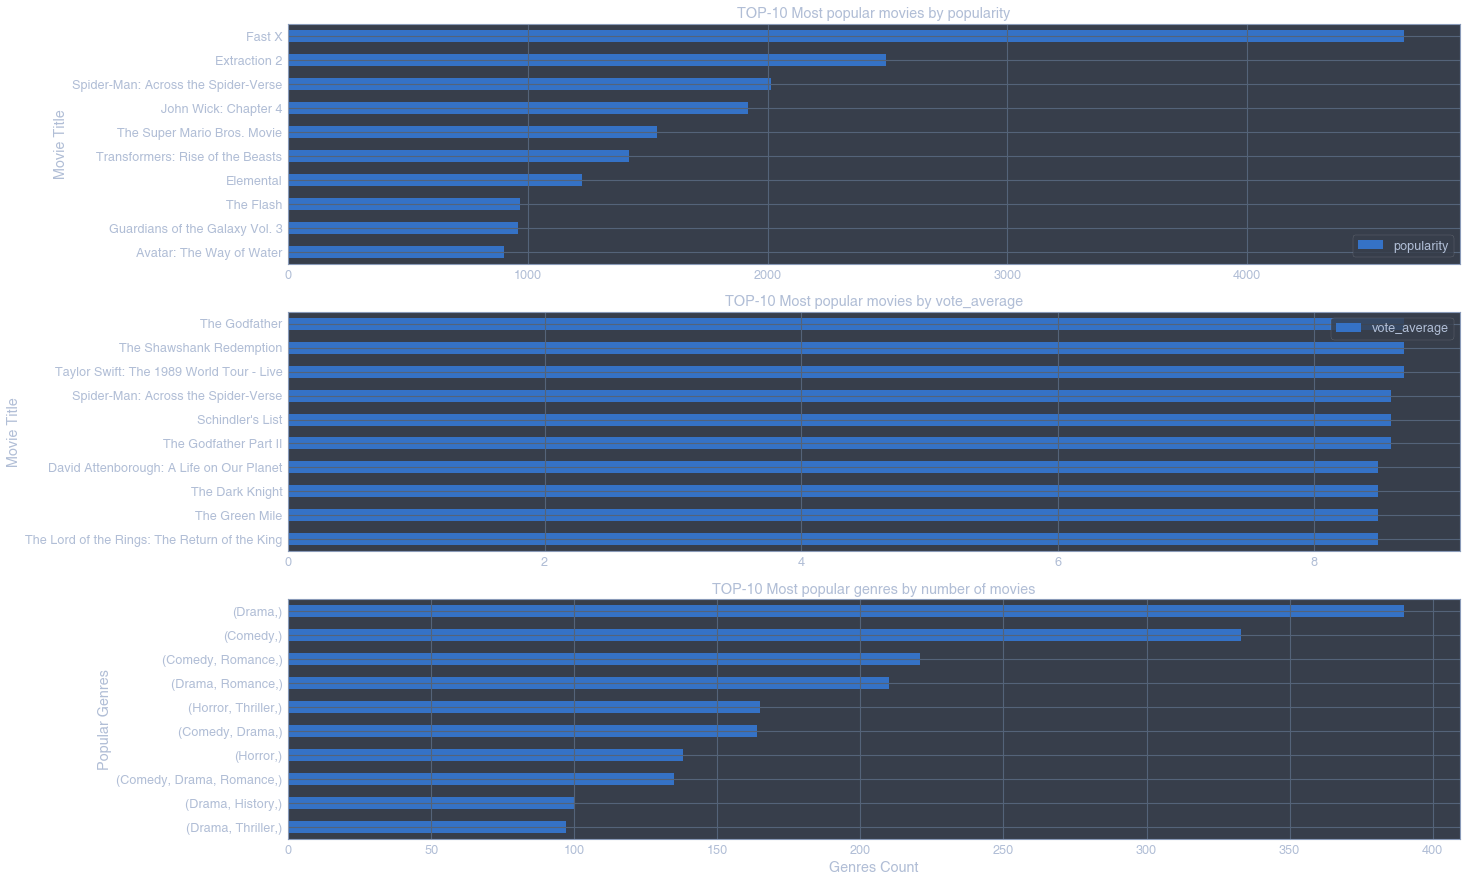

In [49]:
movies_by_popularity = movies_df.sort_values(['popularity'], ascending=False)\
                                .head(10)[['title', 'popularity']]\
                                .reset_index(drop=True)
movies_by_popularity.set_index('title', inplace=True)

movies_by_vote_average = movies_df.sort_values(['vote_average'], ascending=False)\
                                  .head(10)[['title', 'vote_average']]\
                                  .reset_index(drop=True)
movies_by_vote_average.set_index('title', inplace=True)

genres_by_date = movies_df.groupby('release_date')['genres']\
                          .value_counts()\
                          .to_frame()\
                          .rename(columns={'genres': 'genres_count'})\
                          .reset_index()

fig, ax = plt.subplots(3, 1, figsize=(21, 15))

movies_by_popularity.plot(kind='barh', ax=ax[0]).invert_yaxis()
ax[0].set_title('TOP-10 Most popular movies by popularity')
ax[0].set_ylabel('Movie Title')

movies_by_vote_average.plot(kind='barh', ax=ax[1]).invert_yaxis()
ax[1].set_title('TOP-10 Most popular movies by vote_average')
ax[1].set_ylabel('Movie Title')

genres_by_date.value_counts(['genres']).head(10).plot(kind='barh', x='genres', y='genres_count', ax=ax[2]).invert_yaxis()
ax[2].set_title('TOP-10 Most popular genres by number of movies')
ax[2].set_xlabel('Genres Count')
ax[2].set_ylabel('Popular Genres')

Text(0, 0.5, 'Vote Count')

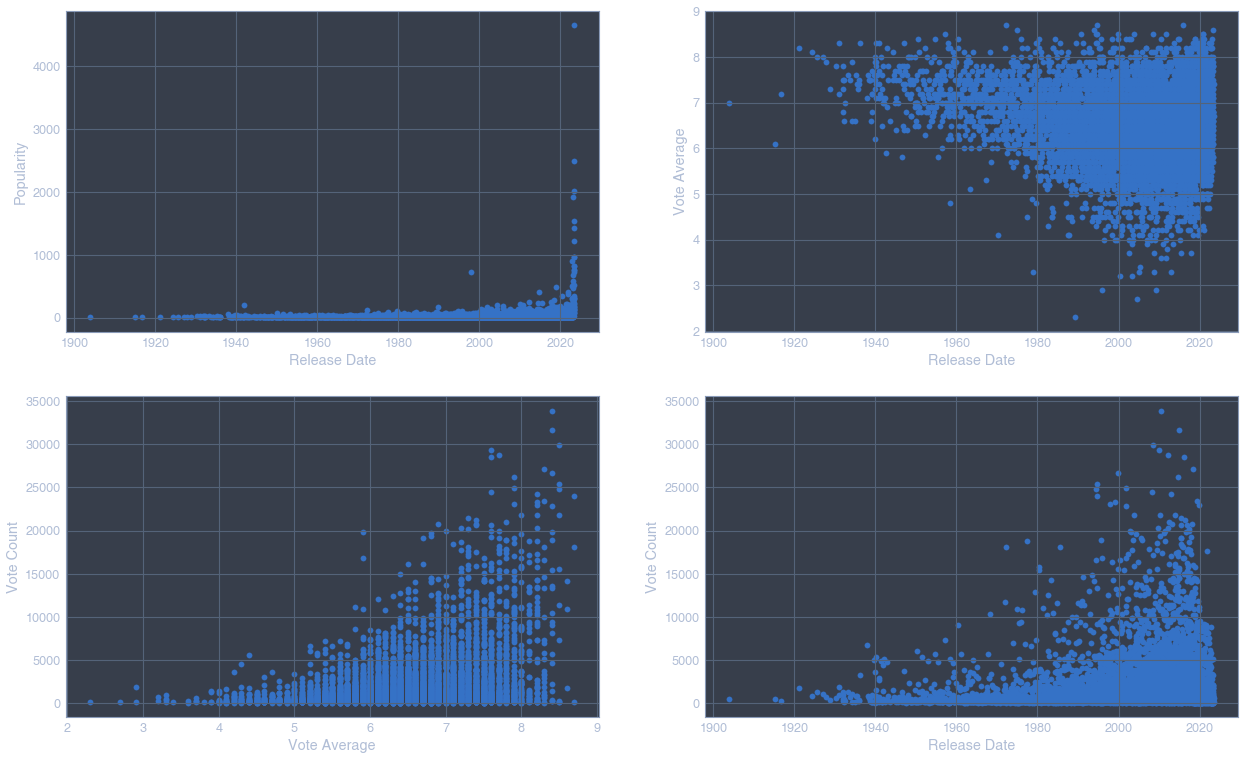

In [50]:
fig, axs = plt.subplots(2, 2, figsize=(21, 13))

axs[0, 0].scatter(movies_df['release_date'], movies_df['popularity'])
axs[0, 0].set_xlabel('Release Date')
axs[0, 0].set_ylabel('Popularity')

axs[0, 1].scatter(movies_df['release_date'], movies_df['vote_average'])
axs[0, 1].set_xlabel('Release Date')
axs[0, 1].set_ylabel('Vote Average')

axs[1, 0].scatter(movies_df['vote_average'], movies_df['vote_count'])
axs[1, 0].set_xlabel('Vote Average')
axs[1, 0].set_ylabel('Vote Count')

axs[1, 1].scatter(movies_df['release_date'], movies_df['vote_count'])
axs[1, 1].set_xlabel('Release Date')
axs[1, 1].set_ylabel('Vote Count')

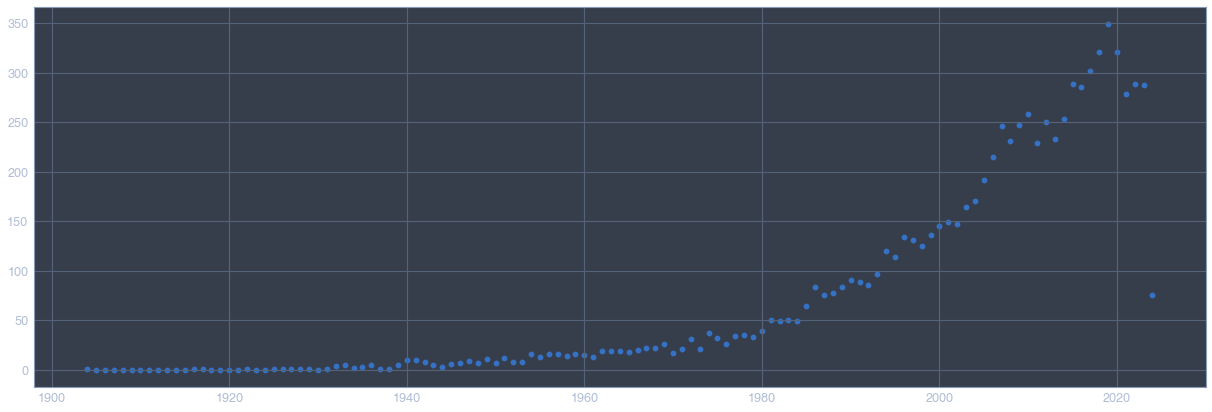

In [51]:
release_date_index = movies_df.copy()
release_date_index.reset_index(inplace=True)
release_date_index.set_index(['release_date'], inplace=True)

movies_by_years = release_date_index.resample('1Y').count()['id']

fig, ax = plt.subplots(figsize=(21, 7))
ax.scatter(movies_by_years.index, movies_by_years)

## Helpers

In [18]:
def flat_list(nest):
    return [egg for one_more_nest in nest for egg in one_more_nest]


def get_vectors(df: pd.DataFrame, unique_list: list, vector_GENRES: pd.DataFrame)->pd.DataFrame:
    df_vectors = pd.DataFrame(0, index=unique_list, columns=vector_GENRES.columns)
    df_vectors.head()
    
    for _id in df.index:
        row = df.loc[_id][0]
        genres_vector = vector_GENRES.loc[_id].to_list()
        for item in row:
            df_vectors.loc[item] += genres_vector
    
    return df_vectors


def get_sum_of_vectors(df: pd.DataFrame, df_vectors: pd.DataFrame, unique_list: list)->pd.DataFrame:
    df_vectors_sum = pd.DataFrame(index=df.index, columns=unique_list)
    
    def get_sum(row):
        _id = row.name
        _ids = df_vectors.loc[df.loc[_id][0]]
        
        return _ids.sum()

    df_vectors_sum = df.apply(get_sum, axis=1)
    
    return df_vectors_sum


def clean_data(feature_name: str)->pd.DataFrame:
    list_of_the_dicts = []
    for w in movies_df[feature_name].to_list():
        list_of_the_dicts.append(literal_eval(w))
    
    list_of_the_lists = [[k_d['name'] for k_d in k_l] for k_l in list_of_the_dicts]
    
    feature_df = pd.DataFrame(index=movies_df.index,
                              columns=[feature_name+'_list'],
                              data=np.array(list_of_the_lists, dtype=object))
    unique_features = list(set(flat_list(list_of_the_lists)))
    
    return feature_df, unique_features

def _get_sum_of_vectors(feature_name: str)->pd.DataFrame:
    feature_df, unique_features = clean_data(feature_name)
    feature_vectors = get_vectors(feature_df, unique_features, vector_GENRES)
    feature_sum_vectors = get_sum_of_vectors(feature_df, feature_vectors, GENRES)
    
    return feature_sum_vectors
    

## Genres

In [19]:
genres_list = list(movies_df['genres'].unique())

for i, g in enumerate(genres_list):
    genres_list[i] = g.split(', ')
    
genres_list[:20]

[['Action', 'Crime', 'Thriller'],
 ['Action', 'Thriller'],
 ['Action', 'Thriller', 'Crime'],
 ['Action', 'Adventure', 'Animation', 'Science Fiction'],
 ['Animation', 'Family', 'Adventure', 'Fantasy', 'Comedy'],
 ['Action', 'Adventure', 'Science Fiction'],
 ['Animation', 'Comedy', 'Family', 'Fantasy', 'Romance'],
 ['Mystery', 'Thriller', 'Science Fiction'],
 ['Science Fiction', 'Action', 'Adventure'],
 ['Action', 'Science Fiction', 'Adventure'],
 ['Science Fiction', 'Adventure', 'Action'],
 ['Adventure', 'Family', 'Fantasy', 'Romance'],
 ['Thriller', 'Horror'],
 ['Horror', 'Thriller'],
 ['War', 'Action', 'Thriller'],
 ['Drama', 'Romance'],
 ['Comedy', 'Action', 'Fantasy'],
 ['Comedy', 'Drama'],
 ['Animation', 'Family', 'Fantasy', 'Adventure', 'Comedy'],
 ['Drama', 'Action']]

In [20]:
GENRES = flat_list(genres_list)
GENRES = list(set(GENRES))

GENRES

['Thriller',
 'Drama',
 'Comedy',
 'Fantasy',
 'History',
 'War',
 'Crime',
 'Family',
 'Music',
 'Horror',
 'Romance',
 'Action',
 'TV Movie',
 'Animation',
 'Western',
 'Adventure',
 'Science Fiction',
 'Mystery',
 'Documentary']

In [21]:
genres_counter = {}
l = []
for g in GENRES:
    for gs in genres_list:
        if g in gs:
            l.extend(gs)
    genres_counter[g] = dict(Counter(l))
    l = []

genres_counter['Animation']

{'Action': 118,
 'Adventure': 202,
 'Animation': 378,
 'Science Fiction': 90,
 'Family': 280,
 'Fantasy': 151,
 'Comedy': 200,
 'Romance': 26,
 'Music': 32,
 'Drama': 31,
 'TV Movie': 30,
 'Crime': 13,
 'Thriller': 10,
 'Horror': 15,
 'Mystery': 38,
 'Western': 7,
 'War': 5,
 'History': 3}

In [22]:
genres_df = pd.DataFrame(columns=GENRES, index=GENRES)

for genre in GENRES:
    g = {}
    for u_genre in GENRES:
        if u_genre in genres_counter[genre].keys():
            g[u_genre] =  genres_counter[genre][u_genre]
        else:
            g[u_genre] = 0
    genres_df.loc[genre] = g

genres_df

,Thriller,Drama,Comedy,Fantasy,History,War,Crime,Family,Music,Horror,Romance,Action,TV Movie,Animation,Western,Adventure,Science Fiction,Mystery,Documentary
Thriller,584,271,92,67,37,35,191,7,4,152,66,249,14,10,18,104,145,186,1
Drama,271,767,174,115,117,91,162,106,58,79,185,195,45,31,48,155,92,136,6
Comedy,92,174,754,230,10,14,112,340,86,73,142,203,71,200,23,291,122,79,5
Fantasy,67,115,230,514,1,3,15,242,44,94,79,142,37,151,5,232,97,47,0
History,37,117,10,1,142,50,19,7,7,3,20,47,6,3,4,33,0,8,3
War,35,91,14,3,50,127,2,3,2,5,24,58,4,5,2,35,8,5,0
Crime,191,162,112,15,19,2,340,15,9,36,37,151,9,13,12,43,25,95,3
Family,7,106,340,242,7,3,15,556,64,12,75,129,71,280,8,305,100,39,1
Music,4,58,86,44,7,2,9,64,144,7,42,8,20,32,1,28,7,5,3
Horror,152,79,73,94,3,5,36,12,7,325,17,105,12,15,6,48,96,81,1


In [23]:
genres_cs = pd.DataFrame(data=cosine_similarity(genres_df), index=genres_df.index, columns=genres_df.columns)

Text(0.5, 1.0, 'Correlation')

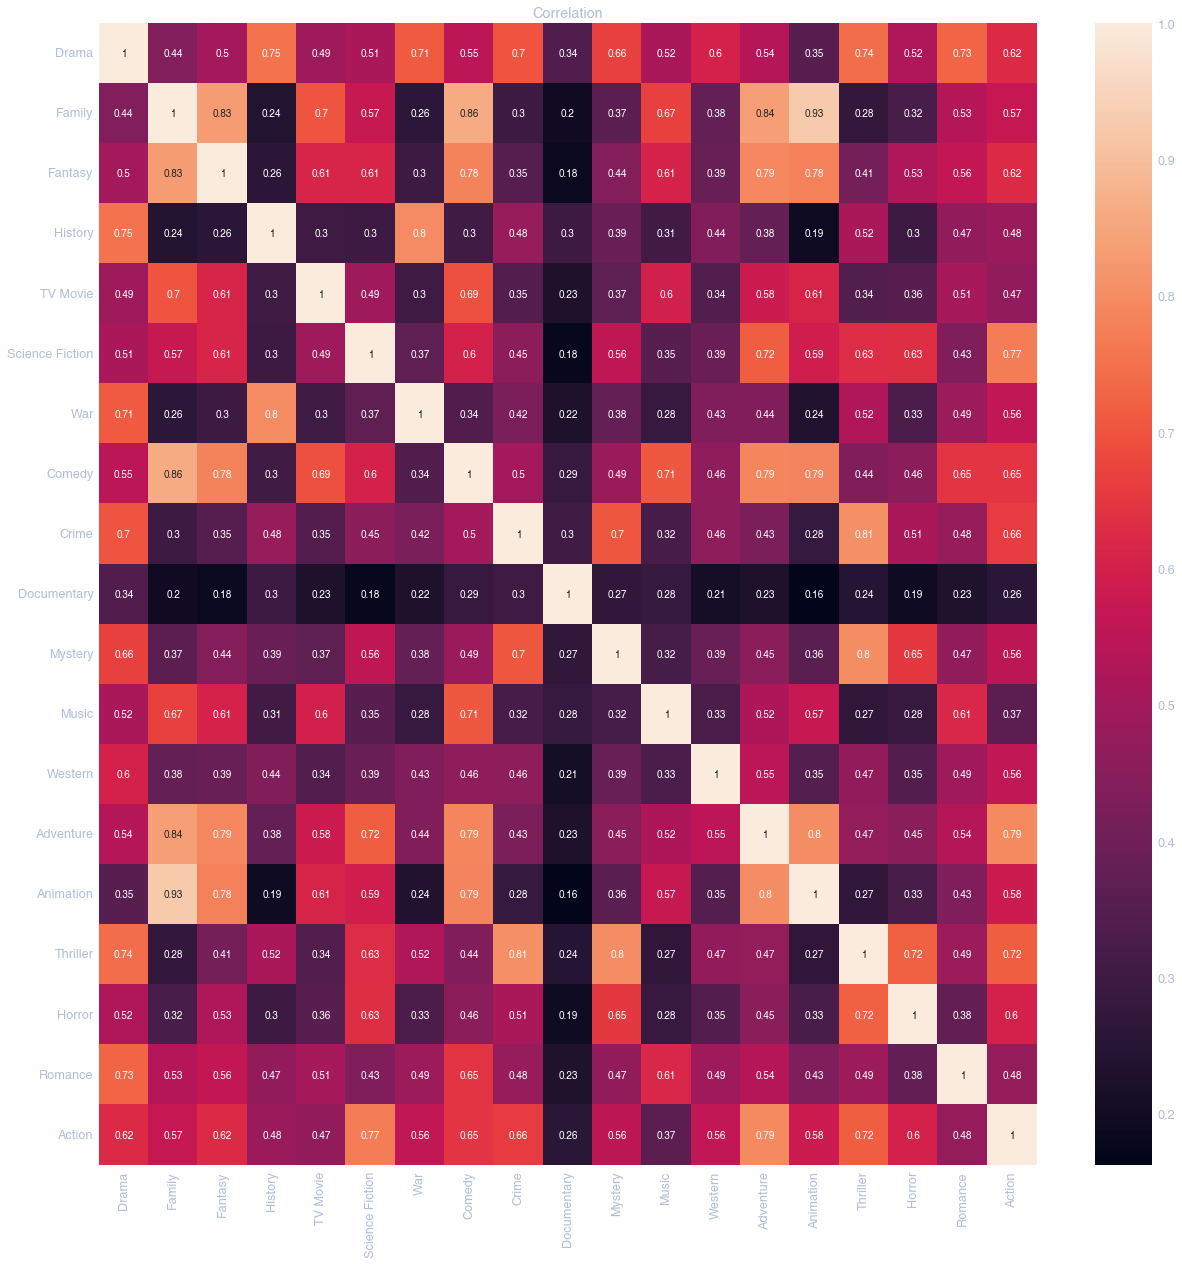

In [59]:
plt.figure(figsize=(21, 21))
sns.heatmap(genres_cs, annot=True)
plt.title('Correlation')

### Vector of Genres

In [24]:
vector_GENRES = pd.DataFrame(index=movies_df.index, columns=GENRES)
vector_GENRES.head()

,Thriller,Drama,Comedy,Fantasy,History,War,Crime,Family,Music,Horror,Romance,Action,TV Movie,Animation,Western,Adventure,Science Fiction,Mystery,Documentary
id,,,,,,,,,,,,,,,,,,,
385687,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
697843,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
603692,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
569094,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
502356,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
genres = movies_df['genres'].to_frame()

In [26]:
for i in range(genres.shape[0]):
    df = np.full(len(GENRES), 0)
    
    for j in str(genres['genres'].iloc[i]).split(', '):
        df[GENRES.index(j)] = 1

    vector_GENRES.iloc[i] = df
        
vector_GENRES.head()

,Thriller,Drama,Comedy,Fantasy,History,War,Crime,Family,Music,Horror,Romance,Action,TV Movie,Animation,Western,Adventure,Science Fiction,Mystery,Documentary
id,,,,,,,,,,,,,,,,,,,
385687,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0
697843,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
603692,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0
569094,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,1,0,0
502356,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0


## Get Keywords Sum of Vectors

In [26]:
keywords_sum_vectors = _get_sum_of_vectors('keywords')
keywords_sum_vectors.head(10)

,Thriller,Fantasy,Drama,Comedy,Crime,Animation,Romance,Action,War,Documentary,Mystery,Horror,Science Fiction,History,Music,Family,TV Movie,Western,Adventure
id,,,,,,,,,,,,,,,,,,,
385687,331,114,237,291,169,97,80,370,11,2,72,210,134,15,13,175,16,24,230
697843,187,74,79,165,73,63,26,251,16,1,42,140,114,5,8,98,12,2,177
603692,544,188,458,521,423,137,169,653,15,5,152,206,234,24,36,202,15,8,378
569094,266,295,138,359,161,313,46,830,10,3,92,211,501,1,15,232,29,8,555
502356,129,177,161,500,78,197,100,304,11,4,44,85,163,17,36,252,3,11,338
667538,146,109,163,374,62,150,78,281,8,4,50,89,313,15,37,206,9,7,263
976573,21,17,21,16,8,17,7,15,0,1,6,15,9,3,0,14,0,1,11
536437,9,1,4,0,1,0,0,2,0,0,5,3,2,0,0,0,1,0,0
298618,165,268,106,333,124,274,39,744,15,3,71,86,417,12,12,192,13,12,516


## Get Cast Sum of Vectors

In [28]:
cast_sum_vectors = _get_sum_of_vectors('cast')
cast_sum_vectors.head(10)

,Thriller,Fantasy,Drama,Comedy,Crime,Animation,Romance,Action,War,Documentary,Mystery,Horror,Science Fiction,History,Music,Family,TV Movie,Western,Adventure
id,,,,,,,,,,,,,,,,,,,
385687,190,53,130,135,174,28,41,281,11,4,23,21,75,13,5,49,5,1,133
697843,72,26,33,31,26,3,3,118,3,1,9,8,30,3,0,6,1,1,56
603692,135,43,110,71,86,23,22,172,7,3,24,27,52,12,4,27,6,6,77
569094,113,155,236,399,76,402,91,367,12,1,48,30,256,26,32,237,8,13,433
502356,47,167,67,408,31,405,33,187,1,3,44,29,119,9,28,342,28,3,269
667538,58,52,81,94,34,87,24,149,3,3,25,25,113,11,8,69,7,1,140
976573,7,38,18,58,2,40,30,15,0,0,2,6,14,5,3,40,0,1,20
536437,102,24,87,48,36,4,20,75,5,1,48,14,70,11,1,9,0,5,35
298618,140,76,185,132,84,20,66,221,20,3,40,25,121,27,6,43,4,6,171


## Get Crew Sum of Vectors

### Clean Data

In [18]:
literal_eval(movies_df.loc[385687]['crew'])[:10]

[{'crew_id': 1302, 'name': 'Susie Figgis', 'department': 'Production'},
 {'crew_id': 2519,
  'name': 'Sanja Milković Hays',
  'department': 'Costume & Make-Up'},
 {'crew_id': 7239, 'name': 'Peter Brown', 'department': 'Sound'},
 {'crew_id': 7239, 'name': 'Peter Brown', 'department': 'Sound'},
 {'crew_id': 10570,
  'name': 'Joseph M. Caracciolo Jr.',
  'department': 'Production'},
 {'crew_id': 10570,
  'name': 'Joseph M. Caracciolo Jr.',
  'department': 'Production'},
 {'crew_id': 6041, 'name': 'Brian Tyler', 'department': 'Sound'},
 {'crew_id': 8162, 'name': 'Gary Scott Thompson', 'department': 'Writing'},
 {'crew_id': 11874, 'name': 'Neal H. Moritz', 'department': 'Production'},
 {'crew_id': 13162, 'name': 'Dov Samuel', 'department': 'Editing'}]

In [31]:
significant_departments = ['Writing', 'Production', 'Directing', 'Camera', 'Visual Effects']

In [32]:
list_of_the_dicts = []
for i in movies_df.index:
    crew = literal_eval(movies_df.loc[i]['crew'])
    crew_list = []
    for c in crew:
        if c['department'] in significant_departments:
            crew_list.append(c)
    list_of_the_dicts.append(crew_list)


In [33]:
list_of_the_dicts[1]

[{'crew_id': 7232, 'name': 'Sarah Halley Finn', 'department': 'Production'},
 {'crew_id': 5551, 'name': 'Christopher Markus', 'department': 'Production'},
 {'crew_id': 5552, 'name': 'Stephen McFeely', 'department': 'Production'},
 {'crew_id': 19271, 'name': 'Anthony Russo', 'department': 'Production'},
 {'crew_id': 19271, 'name': 'Anthony Russo', 'department': 'Writing'},
 {'crew_id': 19272, 'name': 'Joe Russo', 'department': 'Production'},
 {'crew_id': 19272, 'name': 'Joe Russo', 'department': 'Writing'},
 {'crew_id': 19272, 'name': 'Joe Russo', 'department': 'Writing'},
 {'crew_id': 74568, 'name': 'Chris Hemsworth', 'department': 'Production'},
 {'crew_id': 68217, 'name': 'Eric Gitter', 'department': 'Production'},
 {'crew_id': 1104904, 'name': 'Benjamin Grayson', 'department': 'Production'},
 {'crew_id': 1120883, 'name': 'Sam Hargrave', 'department': 'Directing'},
 {'crew_id': 1120883, 'name': 'Sam Hargrave', 'department': 'Production'},
 {'crew_id': 1193191, 'name': 'Patrick Newall

In [34]:
movies_df.shape, len(list_of_the_dicts)

((8388, 11), 8388)

In [35]:
crew_data = [[k_d['name'] for k_d in k_l] for k_l in list_of_the_dicts]

crew_data[0]

['Susie Figgis',
 'Joseph M. Caracciolo Jr.',
 'Joseph M. Caracciolo Jr.',
 'Gary Scott Thompson',
 'Neal H. Moritz',
 'Vin Diesel',
 'Sharon Smith Holley',
 'Daniel Acon',
 'Mark Bomback',
 'Alexander Witt',
 'Alexander Witt',
 'Louis Leterrier',
 'Jeff Kirschenbaum',
 'Chris Morgan',
 'Amanda Lewis',
 'Justin Lin',
 'Justin Lin',
 'Justin Lin',
 'Stephen F. Windon',
 'Samantha Vincent',
 'Spiro Razatos',
 'Peter Chiang',
 'Hal Couzens',
 'Olivier Schneider',
 'Dan Mazeau',
 'Dan Mazeau',
 'Zach Dean',
 'Maurizio Salvatori',
 'Meg Guidon',
 'Karen M. Murphy',
 'Peter Mountain',
 'Chad Wiebe',
 'Ben Howdeshell',
 'Aleksandar Pejic',
 'Zoe Morgan',
 'Peter Wilke',
 'Lex Donovan',
 'Jeremiah Kent',
 'Stanislas de Lesquen',
 'Craig Grossmueller',
 'Taylor Matheson',
 'David Cain',
 'David Cain',
 'Kirsty Kinnear',
 'Vincent Lascoumes',
 'Michael Grobe',
 'Daniele Postiglione',
 'Steve Ellingworth',
 'Paul Jones',
 'Carlo Postiglione',
 'Mariluz Noto',
 'François Lambert',
 'Tulio Duenas',

In [36]:
crew_df = pd.DataFrame(index=movies_df.index,
                       columns=['crew_list'],
                       data=np.array(crew_data, dtype=object))

crew_df.head()

,crew_list
id,
385687,"[Susie Figgis, Joseph M. Caracciolo Jr., Josep..."
697843,"[Sarah Halley Finn, Christopher Markus, Stephe..."
603692,"[Keanu Reeves, Henning Molfenter, Charlie Woeb..."
569094,"[Stan Lee, Steve Ditko, Avi Arad, Mary Hidalgo..."
502356,"[Chris Meledandri, Robert Taylor, Mark Walton,..."


In [37]:
unique_crew = list(set(flat_list(crew_data)))

len(unique_crew)

86925

In [38]:
simple_vectors_crew = get_vectors(crew_df, unique_crew, vector_GENRES)
simple_vectors_crew.head()

,Thriller,Fantasy,Drama,Comedy,Crime,Animation,Romance,Action,War,Documentary,Mystery,Horror,Science Fiction,History,Music,Family,TV Movie,Western,Adventure
Cara Malek,0,1,0,1,0,2,0,1,0,0,0,0,1,0,0,2,0,0,1
Peter Fudakowski,0,0,0,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
Shen Bo,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1
Jeremy Phoenix,3,1,2,0,1,0,0,0,0,0,1,1,1,1,1,1,0,0,0
Dániel Tóth,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0


In [39]:
crew_sum_vectors = get_sum_of_vectors(crew_df, simple_vectors_crew, GENRES)
crew_sum_vectors.head()

,Thriller,Fantasy,Drama,Comedy,Crime,Animation,Romance,Action,War,Documentary,Mystery,Horror,Science Fiction,History,Music,Family,TV Movie,Western,Adventure
id,,,,,,,,,,,,,,,,,,,
385687,335,126,219,158,250,4,75,488,21,1,44,58,150,33,8,69,0,4,268
697843,181,45,94,56,58,8,23,275,10,0,19,28,104,8,0,17,0,1,127
603692,214,57,104,100,119,5,37,247,15,2,45,49,91,16,3,10,0,4,110
569094,80,196,96,296,45,776,22,791,6,1,25,37,645,13,12,250,7,4,838
502356,5,177,7,270,6,281,0,35,0,0,4,5,14,0,14,270,1,0,223


## I Want To Watch Something Like...

In [19]:
# data for test purpose only
sum_vectors_keywords = pd.read_csv('data/test_data/keywords_sum_vectors.csv', index_col=0)
sum_vectors_cast = pd.read_csv('data/test_data/cast_sum_vectors.csv', index_col=0)
sum_vectors_crew = pd.read_csv('data/test_data/crew_sum_vectors.csv', index_col=0)

In [20]:
class Vectors_CS:
    __VECTORS = {
        'keywords': sum_vectors_keywords,
        'cast': sum_vectors_cast,
        'crew': sum_vectors_crew,
    }
    
    def __init__(self, like):
        self.like = like
        self.similar = similar
        self.cosine_similarity = { v:[] for v in self.__VECTORS.keys() }
        self.calc_cosine_similarity()
        
    def calc_cosine_similarity(self):
        like_vectors = self.get_vectors(self.like.index)
        similar_vectors = self.get_vectors(self.similar.index)
    
        for v in self.__VECTORS.keys():
            cs = cosine_similarity(
                like_vectors[v],
                similar_vectors[v]
            )
            self.cosine_similarity[v] = self.get_cosine_similarity_df(cs.transpose())

    def get_cosine_similarity_df(self, data)->pd.DataFrame:
        df = pd.DataFrame(
            index=self.similar.index,
            columns=self.like['title'],
            data=data
        )
        return df
    
    def get_vectors(self, idxs)->dict:
        vectors = {}
        for v in self.__VECTORS.keys():
            vectors[v] = self.__VECTORS[v].loc[idxs]
        
        return vectors
    
    def gather_idxs(self, threshold=0.96)->list:
        idxs = []
        for title in self.like['title']:
            for v in self.__VECTORS.keys():
                idxs += self.cosine_similarity[v][self.cosine_similarity[v][title]>threshold][title].index.to_list()
        
        return list(set(idxs))
    
    def get_cosine_similarity(self)->dict:
        return self.cosine_similarity

    

In [22]:
class IWantToWatchSomethingLike:
    def __init__(self, i_like:list):
        self.like = i_like
        self.like_df = movies_df[movies_df['title'].isin(self.like)]
        
        self.cs_THRESHOLD = 0.98
        
        self.vectors = Vectors_CS(self.like_df)
    
    def show_recommendation(self, amount=10, sorted_by='vote_average')->pd.DataFrame:
        self.idxs_cs = self.vectors.gather_idxs(self.cs_THRESHOLD)
        recommendation = movies_df.loc[self.idxs_cs]

        if sorted_by in recommendation.columns and amount < recommendation.shape[0]:
            return recommendation.sort_values([sorted_by], ascending=False)[:amount]
        
        return recommendation
        
    def show_me_what_i_like(self)->pd.DataFrame:
        return self.like_df
    
    def show_more_similar(self, amount=10, sorted_by='vote_average')->pd.DataFrame:
        if self.cs_THRESHOLD <= 1.0:
            self.cs_THRESHOLD += 0.01
            return self.show_recommendation(amount, sorted_by)
        else:
            print('THRESHOLD equal 1')
    


In [23]:
what_to_watch = IWantToWatchSomethingLike(['Aliens', 'Starship Troopers'])
what_to_watch.show_me_what_i_like()

,genre_ids,overview,popularity,release_date,title,vote_average,vote_count,genres,cast,crew,keywords
id,,,,,,,,,,,
679,"[28, 53, 878]",When Ripley's lifepod is found by a salvage cr...,59.005,1986-07-18,Aliens,7.9,8542,"Action, Thriller, Science Fiction","[{'cast_id': 10205, 'name': 'Sigourney Weaver'...","[{'crew_id': 8380, 'name': 'Michael Lamont', '...","[{'id': 803, 'name': 'android'}, {'id': 1603, ..."
563,"[12, 28, 53, 878]","Set in the future, the story follows a young s...",28.171,1997-11-07,Starship Troopers,7.0,4268,"Adventure, Action, Thriller, Science Fiction","[{'cast_id': 27763, 'name': 'Casper Van Dien',...","[{'crew_id': 3686, 'name': 'Johanna Ray', 'dep...","[{'id': 305, 'name': 'moon'}, {'id': 818, 'nam..."


In [25]:
what_to_watch.show_recommendation(sorted_by='vote_average', amount=25)

,genre_ids,overview,popularity,release_date,title,vote_average,vote_count,genres,cast,crew,keywords
id,,,,,,,,,,,
550,"[18, 53, 35]",A ticking-time-bomb insomniac and a slippery s...,73.566,1999-10-15,Fight Club,8.4,26647,"Drama, Thriller, Comedy","[{'cast_id': 819, 'name': 'Edward Norton', 'ch...","[{'crew_id': 376, 'name': 'Arnon Milchan', 'de...","[{'id': 818, 'name': 'based on novel or book'}..."
603,"[28, 878]","Set in the 22nd century, The Matrix tells the ...",66.895,1999-03-30,The Matrix,8.2,23366,"Action, Science Fiction","[{'cast_id': 6384, 'name': 'Keanu Reeves', 'ch...","[{'crew_id': 123, 'name': 'Barrie M. Osborne',...","[{'id': 83, 'name': 'saving the world'}, {'id'..."
280,"[28, 53, 878]",Nearly 10 years have passed since Sarah Connor...,69.226,1991-07-03,Terminator 2: Judgment Day,8.1,11448,"Action, Thriller, Science Fiction","[{'cast_id': 1100, 'name': 'Arnold Schwarzeneg...","[{'crew_id': 563, 'name': 'Dody Dorn', 'depart...","[{'id': 679, 'name': 'cyborg'}, {'id': 1366, '..."
62,"[878, 9648, 12]",Humanity finds a mysterious object buried bene...,48.426,1968-04-02,2001: A Space Odyssey,8.1,10314,"Science Fiction, Mystery, Adventure","[{'cast_id': 245, 'name': 'Keir Dullea', 'char...","[{'crew_id': 240, 'name': 'Stanley Kubrick', '...","[{'id': 305, 'name': 'moon'}, {'id': 306, 'nam..."
348,"[27, 878]","During its return to the earth, commercial spa...",62.215,1979-05-25,Alien,8.1,12914,"Horror, Science Fiction","[{'cast_id': 10205, 'name': 'Sigourney Weaver'...","[{'crew_id': 578, 'name': 'Ridley Scott', 'dep...","[{'id': 803, 'name': 'android'}, {'id': 1612, ..."
1091,"[27, 9648, 878]",A team of American scientists investigate the ...,46.562,1982-06-25,The Thing,8.0,6063,"Horror, Mystery, Science Fiction","[{'cast_id': 6856, 'name': 'Kurt Russell', 'ch...","[{'crew_id': 511, 'name': 'Larry J. Franco', '...","[{'id': 818, 'name': 'based on novel or book'}..."
78,"[878, 18, 53]",In the smog-choked dystopian Los Angeles of 20...,56.838,1982-06-25,Blade Runner,7.9,12501,"Science Fiction, Drama, Thriller","[{'cast_id': 3, 'name': 'Harrison Ford', 'char...","[{'crew_id': 473, 'name': 'Brian Tufano', 'dep...","[{'id': 310, 'name': 'artificial intelligence'..."
679,"[28, 53, 878]",When Ripley's lifepod is found by a salvage cr...,59.005,1986-07-18,Aliens,7.9,8542,"Action, Thriller, Science Fiction","[{'cast_id': 10205, 'name': 'Sigourney Weaver'...","[{'crew_id': 8380, 'name': 'Michael Lamont', '...","[{'id': 803, 'name': 'android'}, {'id': 1603, ..."
438631,"[878, 12]","Paul Atreides, a brilliant and gifted young ma...",89.072,2021-09-15,Dune,7.8,9016,"Science Fiction, Adventure","[{'cast_id': 1190668, 'name': 'Timothée Chalam...","[{'crew_id': 27, 'name': 'Eric Roth', 'departm...","[{'id': 530, 'name': 'prophecy'}, {'id': 818, ..."


In [106]:
what_to_watch.show_more_similar()

,genre_ids,overview,popularity,release_date,title,vote_average,vote_count,genres,cast,crew,keywords
id,,,,,,,,,,,
603,"[28, 878]","Set in the 22nd century, The Matrix tells the ...",66.895,1999-03-30,The Matrix,8.2,23366,"Action, Science Fiction","[{'cast_id': 6384, 'name': 'Keanu Reeves', 'ch...","[{'crew_id': 123, 'name': 'Barrie M. Osborne',...","[{'id': 83, 'name': 'saving the world'}, {'id'..."
348,"[27, 878]","During its return to the earth, commercial spa...",62.215,1979-05-25,Alien,8.1,12914,"Horror, Science Fiction","[{'cast_id': 10205, 'name': 'Sigourney Weaver'...","[{'crew_id': 578, 'name': 'Ridley Scott', 'dep...","[{'id': 803, 'name': 'android'}, {'id': 1612, ..."
62,"[878, 9648, 12]",Humanity finds a mysterious object buried bene...,48.426,1968-04-02,2001: A Space Odyssey,8.1,10314,"Science Fiction, Mystery, Adventure","[{'cast_id': 245, 'name': 'Keir Dullea', 'char...","[{'crew_id': 240, 'name': 'Stanley Kubrick', '...","[{'id': 305, 'name': 'moon'}, {'id': 306, 'nam..."
438631,"[878, 12]","Paul Atreides, a brilliant and gifted young ma...",89.072,2021-09-15,Dune,7.8,9016,"Science Fiction, Adventure","[{'cast_id': 1190668, 'name': 'Timothée Chalam...","[{'crew_id': 27, 'name': 'Eric Roth', 'departm...","[{'id': 530, 'name': 'prophecy'}, {'id': 818, ..."
9693,"[18, 28, 53, 878]","In 2027, in a chaotic world in which humans ca...",24.185,2006-09-22,Children of Men,7.6,6355,"Drama, Action, Thriller, Science Fiction","[{'cast_id': 2296, 'name': 'Clive Owen', 'char...","[{'crew_id': 2952, 'name': 'Avy Kaufman', 'dep...","[{'id': 318, 'name': 'police state'}, {'id': 3..."
871,"[878, 12, 18, 28]",Astronaut Taylor crash lands on a distant plan...,49.489,1968-02-07,Planet of the Apes,7.6,2991,"Science Fiction, Adventure, Drama, Action","[{'cast_id': 10017, 'name': 'Charlton Heston',...","[{'crew_id': 881, 'name': 'Irving Rosenberg', ...","[{'id': 311, 'name': 'human evolution'}, {'id'..."
137113,"[28, 878]",Major Bill Cage is an officer who has never se...,44.810,2014-05-27,Edge of Tomorrow,7.6,12587,"Action, Science Fiction","[{'cast_id': 500, 'name': 'Tom Cruise', 'chara...","[{'crew_id': 1113, 'name': 'Lucinda Syson', 'd...","[{'id': 563, 'name': 'deja vu'}, {'id': 818, '..."
861,"[28, 12, 878]",Construction worker Douglas Quaid's obsession ...,30.484,1990-06-01,Total Recall,7.3,5130,"Action, Adventure, Science Fiction","[{'cast_id': 1100, 'name': 'Arnold Schwarzeneg...","[{'crew_id': 584, 'name': 'Philip K. Dick', 'd...","[{'id': 560, 'name': 'oxygen'}, {'id': 769, 'n..."
199,"[878, 28, 12, 53]","The Borg, a relentless race of cyborgs, are on...",20.963,1996-11-22,Star Trek: First Contact,7.3,1549,"Science Fiction, Action, Adventure, Thriller","[{'cast_id': 2387, 'name': 'Patrick Stewart', ...","[{'crew_id': 373, 'name': 'Doug Jackson', 'dep...","[{'id': 522, 'name': 'borg'}, {'id': 671, 'nam..."


In [107]:
what_to_watch.cs_THRESHOLD

0.99